# Install and Load Library

In [1]:
%pip install yfinance

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d53700f0b8d10a49af3f873fa08aeef0f2cfa264ac3e76368372d0c7b2d9f961
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import yfinance as yf

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout

# Load dataset

In [4]:
# Download data saham MPMX
data = yf.download('MPMX.JK', start='2024-01-01', end='2024-12-18')

# Simpan ke file CSV
data.to_csv('MPMX_data.csv')
print("\nData saham MPMX berhasil diunduh!")

[*********************100%***********************]  1 of 1 completed


Data saham MPMX berhasil diunduh!


In [5]:
raw = pd.read_csv('MPMX_data.csv')[2:]  # 2 baris pertama merupakan header excel
raw.head()
# raw.sample(frac = 1).head()

,Price,Adj Close,Close,High,Low,Open,Volume
2,2024-01-02,936.0848999023438,1050.0,1055.0,1040.0,1050.0,13738600
3,2024-01-03,958.3726196289062,1075.0,1085.0,1050.0,1050.0,20550000
4,2024-01-04,958.3726196289062,1075.0,1090.0,1070.0,1075.0,13636600
5,2024-01-05,958.3726196289062,1075.0,1080.0,1070.0,1075.0,13799500
6,2024-01-08,958.3726196289062,1075.0,1095.0,1070.0,1075.0,17720900


# Pre-processing Dataset

In [6]:
# Drop unused columns

raw.drop(["Adj Close", "Price", "Volume"], axis=1, inplace=True)
raw.head()

,Close,High,Low,Open
2,1050.0,1055.0,1040.0,1050.0
3,1075.0,1085.0,1050.0,1050.0
4,1075.0,1090.0,1070.0,1075.0
5,1075.0,1080.0,1070.0,1075.0
6,1075.0,1095.0,1070.0,1075.0


In [7]:
dataset = raw.values
dataset[:5]

array([['1050.0', '1055.0', '1040.0', '1050.0'],
       ['1075.0', '1085.0', '1050.0', '1050.0'],
       ['1075.0', '1090.0', '1070.0', '1075.0'],
       ['1075.0', '1080.0', '1070.0', '1075.0'],
       ['1075.0', '1095.0', '1070.0', '1075.0']], dtype=object)

In [8]:
# Normalisasi

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data[:5]

array([[0.81818182, 0.74193548, 0.80645161, 0.8125    ],
       [0.96969697, 0.93548387, 0.87096774, 0.8125    ],
       [0.96969697, 0.96774194, 1.        , 0.96875   ],
       [0.96969697, 0.90322581, 1.        , 0.96875   ],
       [0.96969697, 1.        , 1.        , 0.96875   ]])

In [9]:
look_back_range = 60

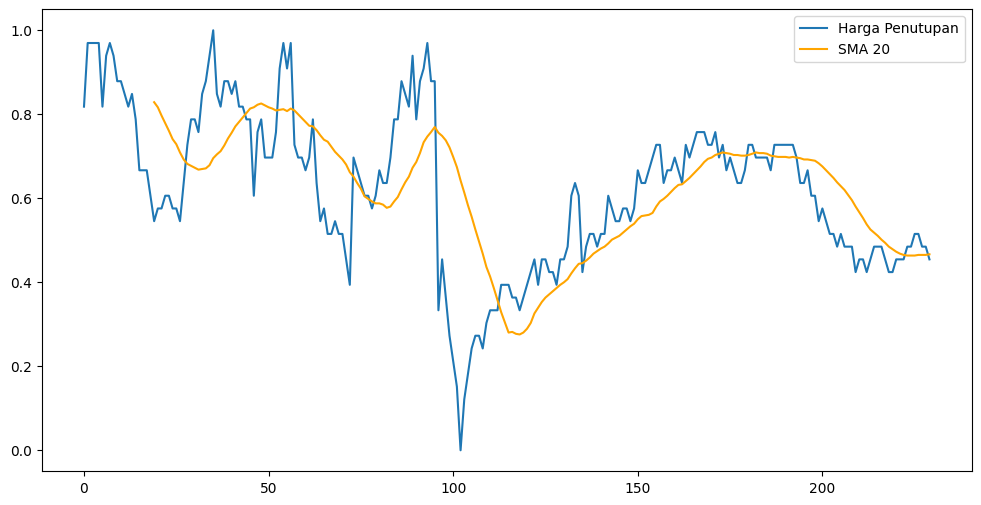

In [13]:
# Calculate Simple Moving Average (SMA)
technical = pd.DataFrame()
technical['SMA_20'] = pd.DataFrame(scaled_data[:, 0]).rolling(window=20).mean()

plt.figure(figsize=(12, 6))
plt.plot(scaled_data[:, 0], label='Harga Penutupan')
plt.plot(technical['SMA_20'], label='SMA 20', color='orange')
plt.legend()
plt.show()

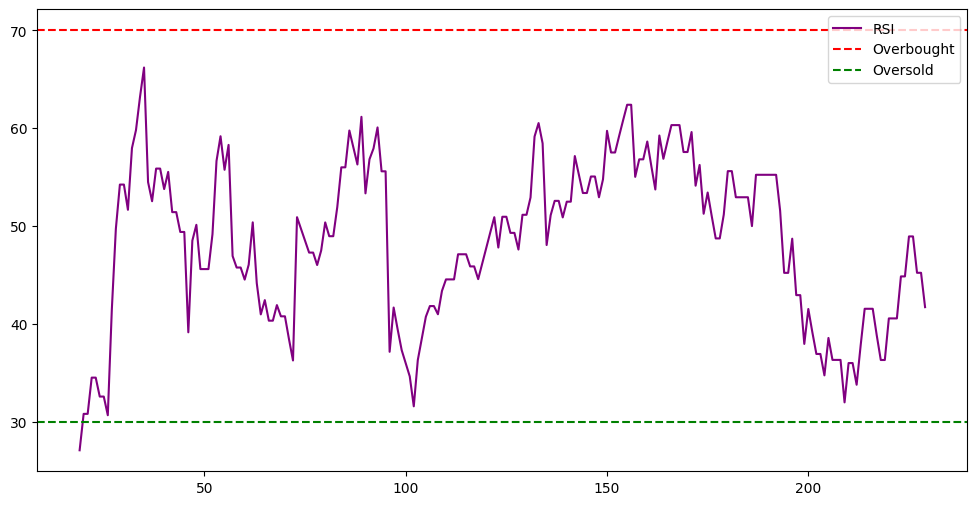

In [14]:
import ta

# Calculate Relative Strength Index (RSI)
technical['RSI'] = ta.momentum.RSIIndicator(pd.Series(scaled_data[:, 0]), window=20).rsi()

plt.figure(figsize=(12, 6))
plt.plot(technical['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.legend()
plt.show()

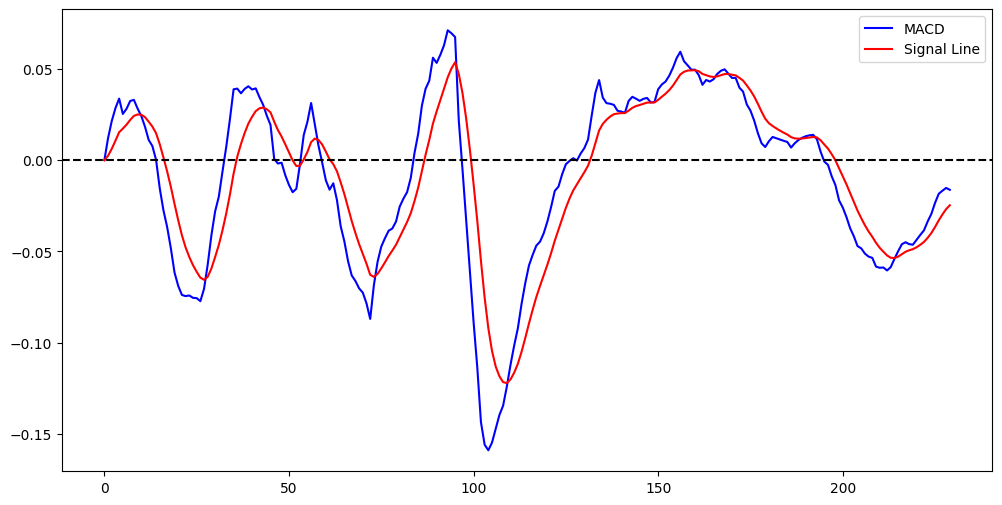

In [15]:
# Calculate Moving Average Convergence Divergence (MACD)
technical['EMA_12'] = pd.Series(scaled_data[:, 0]).ewm(span=12, adjust=False).mean()
technical['EMA_26'] = pd.Series(scaled_data[:, 0]).ewm(span=26, adjust=False).mean()
technical['MACD'] = technical['EMA_12'] - technical['EMA_26']
technical['Signal Line'] = technical['MACD'].ewm(span=9, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(technical['MACD'], label='MACD', color='blue')
plt.plot(technical['Signal Line'], label='Signal Line', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

In [24]:
technical[['SMA_20', 'RSI', 'MACD']][20:].head()

,SMA_20,RSI,MACD
20,0.816667,30.851126,-0.068827
21,0.796970,30.851126,-0.073792
22,0.778788,34.549757,-0.074424
23,0.760606,34.549757,-0.074071
24,0.740909,32.616683,-0.075368


# Train-Test Splitting

In [25]:
data = technical[['SMA_20', 'RSI', 'MACD']][20:].values
data[:5]

array([[ 0.81666667, 30.8511265 , -0.0688266 ],
       [ 0.7969697 , 30.8511265 , -0.07379214],
       [ 0.77878788, 34.54975677, -0.07442425],
       [ 0.76060606, 34.54975677, -0.07407135],
       [ 0.74090909, 32.61668315, -0.07536808]])

In [26]:
training_data_len = math.ceil(len(data) * .8)
train_data = data[0:training_data_len, :]
len(train_data)

168

In [27]:
# Check data shape

np.array(train_data).shape

(168, 3)

In [28]:
# Prepare data for training

x_train = []
y_train = []

for i in range(look_back_range, len(train_data)):
    # Use data of look_back_range days before to be the x
    x_train.append(train_data[i-look_back_range:i])
    prev_close = train_data[i-1, 0]
    cur_close = train_data[i, 0]
    # Labelling y as Naik, Tetap, Turun
    if cur_close > prev_close:
        y_train.append(2)   # Naik
    elif (cur_close == prev_close):
        y_train.append(1)   # Tetap
    else:
        y_train.append(0)   # Turun

In [29]:
print(len(x_train), len(y_train))

108 108


In [30]:
# Check x train

x_train[0]

array([[ 8.16666667e-01,  3.08511265e+01, -6.88266020e-02],
       [ 7.96969697e-01,  3.08511265e+01, -7.37921392e-02],
       [ 7.78787879e-01,  3.45497568e+01, -7.44242456e-02],
       [ 7.60606061e-01,  3.45497568e+01, -7.40713461e-02],
       [ 7.40909091e-01,  3.26166831e+01, -7.53680757e-02],
       [ 7.28787879e-01,  3.26166831e+01, -7.55251365e-02],
       [ 7.09090909e-01,  3.07126542e+01, -7.72048403e-02],
       [ 6.92424242e-01,  4.14973298e+01, -7.03890130e-02],
       [ 6.81818182e-01,  4.97332211e+01, -5.69948161e-02],
       [ 6.77272727e-01,  5.42526732e+01, -4.10166022e-02],
       [ 6.72727273e-01,  5.42526732e+01, -2.80306328e-02],
       [ 6.68181818e-01,  5.16785019e+01, -1.99543387e-02],
       [ 6.69696970e-01,  5.79752848e+01, -6.14735063e-03],
       [ 6.71212121e-01,  5.98127607e+01,  7.15748116e-03],
       [ 6.78787879e-01,  6.32001799e+01,  2.23345994e-02],
       [ 6.95454545e-01,  6.61992303e+01,  3.88056502e-02],
       [ 7.04545455e-01,  5.45090085e+01

In [31]:
# Mengubah data menjadi format numpy array

X_train, Y_train = np.array(x_train), np.array(y_train)

In [33]:
# Reshape to match LSTM input shape

X_train = np.reshape(X_train, (
    X_train.shape[0],
    X_train.shape[1],
    3
))

# Modelling

In [57]:
# Clear previous model (jika ada)
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(X_train.shape[1], 3)),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    tf.keras.layers.GRU(units=50),
    Dropout(0.3),
    Dense(units=3, activation='softmax')   # 3 label output, softmax as probabilities
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,453 (181.46 KB)

 Trainable params: 46,453 (181.46 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Compile the model

model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
# Train the model

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 10
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4821 - loss: 0.9900
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5667 - loss: 0.8822
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6813 - loss: 0.7004
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6657 - loss: 0.7507
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7012 - loss: 0.7010
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6087 - loss: 0.7805
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7025 - loss: 0.6530
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7522 - loss: 0.6108
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7019 - loss: 0.6598
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7601 - loss: 0.6704
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7475 - loss: 0.6247
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy:

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

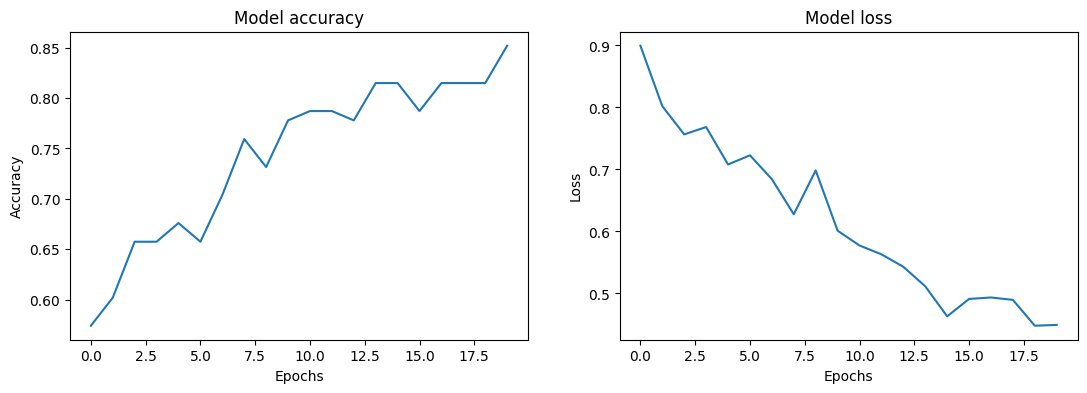

In [ ]:
# Plot training & validation accuracy and loss values side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))  # 1 row, 2 columns

# Accuracy plot
ax1.plot(acc)
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

# Loss plot
ax2.plot(loss)
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

plt.show()

# Evaluate Model

In [62]:
test_data = data[training_data_len-look_back_range:, :]

In [63]:
x_test = []
y_test = []

for i in range(look_back_range, len(test_data)):
    x_test.append(test_data[i-look_back_range:i])
    prev_close = train_data[i-1, 0]
    cur_close = train_data[i, 0]
    if cur_close > prev_close:
        y_test.append(2)
    elif (cur_close == prev_close):
        y_test.append(1)
    else:
        y_test.append(0)

In [64]:
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape for matching
x_test = np.reshape(x_test, (
    x_test.shape[0],
    x_test.shape[1],
    3
))

In [65]:
val_loss, val_acc = model.evaluate(x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7262 - loss: 0.6231 


In [73]:
result = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Confusion Matrix:



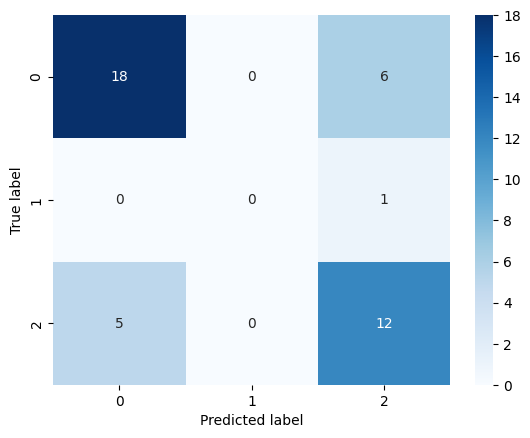

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

res = confusion_matrix(y_test, np.argmax(result, axis=1))
print('Confusion Matrix:\n')
sns.heatmap(res, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Prediction

In [72]:
new_df = raw.copy()

last_n_days = new_df[2:].values
last_n_days_scaled = scaler.transform(last_n_days)

technical_test = pd.DataFrame()
technical_test['SMA_20'] = pd.DataFrame(last_n_days_scaled[:, 0]).rolling(window=20).mean()
technical_test['RSI'] = ta.momentum.RSIIndicator(pd.Series(last_n_days_scaled[:, 0]), window=20).rsi()
technical_test['EMA_12'] = pd.Series(scaled_data[:, 0]).ewm(span=12, adjust=False).mean()
technical_test['EMA_26'] = pd.Series(scaled_data[:, 0]).ewm(span=26, adjust=False).mean()
technical_test['MACD'] = technical_test['EMA_12'] - technical_test['EMA_26']

last_n_days_scaled_technical = technical_test[['SMA_20', 'RSI', 'MACD']][-look_back_range:].values

x_pred = []
x_pred.append(last_n_days_scaled_technical)
x_pred = np.array(x_pred)
x_pred = np.reshape(x_pred, (
    x_pred.shape[0],
    x_pred.shape[1],
    3
))

pred_price = model.predict(x_pred)
labels = ['Turun', 'Tetap', 'Naik']
print(pred_price, labels[np.argmax(pred_price)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[0.0226192  0.00464775 0.9727331 ]] Naik
